<a target="_blank" href="https://colab.research.google.com/github/spbisc97/GastroClassificator/blob/main/BaseVitImplementation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [45]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets
import logging
from torch import nn # if you want to use the nn module for custom classificaiton head
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mtc
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

# Setting up the logger
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Dataset directories
train_root_dir = "./DATASET/TRAIN"
val_root_dir = "./DATASET/VAL"
test_root_dir = "./DATASET/TEST"


INFO:root:Using device: cuda


In [46]:

# Load the feature extractor
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')


# Function to load datasets
def load_dataset(train_root_dir, val_root_dir, test_root_dir, transform=None,normalize=True, feature_extractor=feature_extractor):
    #if transform is None use the VitImageProcessor
    default_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    if transform is None:
        transform = default_transform
    if normalize:
        transform = transforms.Compose([
            transform,
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
            ])
        default_transform = transforms.Compose([
            default_transform,
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ])
    train_dataset = datasets.ImageFolder(train_root_dir, transform=transform)
    logger.info("Training dataset loaded with %d samples", len(train_dataset))
    val_dataset = datasets.ImageFolder(val_root_dir, transform=default_transform)
    logger.info("Validation dataset loaded with %d samples", len(val_dataset))
    test_dataset = datasets.ImageFolder(test_root_dir, transform=default_transform)
    logger.info("Test dataset loaded with %d samples", len(test_dataset))
    return train_dataset, val_dataset, test_dataset

# Function to get labels from dataset
def get_labels(dataset):
    return dataset.classes

# Function to calculate metrics
def calculate_metrics(outputs, targets):
    metrics = {
        "micro_precision": mtc.precision_score(outputs, targets, average="micro", zero_division=0),
        "micro_recall": mtc.recall_score(outputs, targets, average="micro", zero_division=0),
        "micro_f1": mtc.f1_score(outputs, targets, average="micro", zero_division=0),
        "macro_precision": mtc.precision_score(outputs, targets, average="macro", zero_division=0),
        "macro_recall": mtc.recall_score(outputs, targets, average="macro", zero_division=0),
        "macro_f1": mtc.f1_score(outputs, targets, average="macro", zero_division=0),
        "mcc": mtc.matthews_corrcoef(outputs, targets)
    }
    return metrics

# Function to compute evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return calculate_metrics(preds, labels)
    
# Custom collate function to handle the DataLoader output
def custom_collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Wrap DataLoader to be compatible with Trainer
class WrappedDataLoader:
    def __init__(self, dataloader):
        self.dataloader = dataloader

    def __iter__(self):
        for batch in self.dataloader:
            yield custom_collate_fn(batch)

    def __len__(self):
        return len(self.dataloader)

In [47]:

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(10, 10), font_size=12,save_path=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams.update({'figure.autolayout': True})
    plt.rcParams.update({'figure.figsize': figsize})
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    


In [48]:

# Training arguments
metric_name = "micro_f1"
args = TrainingArguments(
    "test-GastroVision",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='./logs',
    logging_steps=30,  # Log every 10 steps
    fp16=True,  # Enable mixed precision training
    #add custom savings 
)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(0.75, 1.33)),  # Added stretch
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Load datasets
train_dataset, val_dataset, test_dataset = load_dataset(train_root_dir, val_root_dir, test_root_dir,transform=transform,normalize=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args.per_device_train_batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=args.per_device_eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=args.per_device_eval_batch_size, shuffle=False, num_workers=4, pin_memory=True)




INFO:root:Training dataset loaded with 4757 samples
INFO:root:Validation dataset loaded with 1587 samples
INFO:root:Test dataset loaded with 1586 samples


In [49]:
# Load the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=len(get_labels(train_dataset)))

# Move the model to the appropriate device
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [50]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_loader.dataset,
    eval_dataset=val_loader.dataset,
    data_collator=custom_collate_fn,
    compute_metrics=compute_metrics,
)



In [51]:
# Train the model
trainer.train()

 10%|█         | 31/298 [00:04<00:41,  6.36it/s]

{'loss': 2.9233, 'grad_norm': 2.26543927192688, 'learning_rate': 1.7986577181208054e-05, 'epoch': 0.1}


 20%|██        | 61/298 [00:09<00:36,  6.47it/s]

{'loss': 2.6389, 'grad_norm': 2.256718158721924, 'learning_rate': 1.5973154362416107e-05, 'epoch': 0.2}


 31%|███       | 91/298 [00:14<00:32,  6.33it/s]

{'loss': 2.4636, 'grad_norm': 2.1351988315582275, 'learning_rate': 1.3959731543624163e-05, 'epoch': 0.3}


 41%|████      | 121/298 [00:19<00:28,  6.32it/s]

{'loss': 2.3178, 'grad_norm': 2.5478084087371826, 'learning_rate': 1.1946308724832217e-05, 'epoch': 0.4}


 51%|█████     | 151/298 [00:23<00:24,  6.01it/s]

{'loss': 2.1848, 'grad_norm': 1.9922314882278442, 'learning_rate': 9.93288590604027e-06, 'epoch': 0.5}


 61%|██████    | 181/298 [00:29<00:19,  5.93it/s]

{'loss': 2.1332, 'grad_norm': 3.0326759815216064, 'learning_rate': 7.919463087248322e-06, 'epoch': 0.6}


 71%|███████   | 211/298 [00:33<00:14,  6.21it/s]

{'loss': 2.0347, 'grad_norm': 2.397965431213379, 'learning_rate': 5.906040268456377e-06, 'epoch': 0.7}


 81%|████████  | 241/298 [00:38<00:08,  6.45it/s]

{'loss': 1.9942, 'grad_norm': 2.510234832763672, 'learning_rate': 3.8926174496644295e-06, 'epoch': 0.81}


 91%|█████████ | 271/298 [00:43<00:04,  5.90it/s]

{'loss': 1.97, 'grad_norm': 2.107468843460083, 'learning_rate': 1.8791946308724835e-06, 'epoch': 0.91}


100%|██████████| 298/298 [00:57<00:00,  6.67it/s]

{'eval_loss': 1.951930284500122, 'eval_micro_precision': 0.55765595463138, 'eval_micro_recall': 0.55765595463138, 'eval_micro_f1': 0.55765595463138, 'eval_macro_precision': 0.18610966790682013, 'eval_macro_recall': 0.1973231953335098, 'eval_macro_f1': 0.15497574932905783, 'eval_mcc': 0.4996031834601778, 'eval_runtime': 10.074, 'eval_samples_per_second': 157.534, 'eval_steps_per_second': 9.927, 'epoch': 1.0}


100%|██████████| 298/298 [00:59<00:00,  5.03it/s]

{'train_runtime': 59.2524, 'train_samples_per_second': 80.284, 'train_steps_per_second': 5.029, 'train_loss': 2.2677509640687266, 'epoch': 1.0}


TrainOutput(global_step=298, training_loss=2.2677509640687266, metrics={'train_runtime': 59.2524, 'train_samples_per_second': 80.284, 'train_steps_per_second': 5.029, 'total_flos': 3.68695472769921e+17, 'train_loss': 2.2677509640687266, 'epoch': 1.0})

In [52]:


# Evaluate the model on the test dataset
test_results = trainer.evaluate(eval_dataset=test_loader.dataset)
logger.info(f"Test results: {test_results}")

# Generate predictions for the test dataset
preds_output = trainer.predict(test_loader.dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Calculate and log the confusion matrix
conf_matrix = confusion_matrix(labels, preds)
logger.info(f"Confusion Matrix:\n{conf_matrix}")


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]
INFO:root:Test results: {'eval_loss': 1.9668159484863281, 'eval_micro_precision': 0.5605296343001261, 'eval_micro_recall': 0.5605296343001261, 'eval_micro_f1': 0.5605296343001261, 'eval_macro_precision': 0.1875031049485691, 'eval_macro_recall': 0.20128687981371113, 'eval_macro_f1': 0.15695935456858845, 'eval_mcc': 0.5040418731627722, 'eval_runtime': 9.7908, 'eval_samples_per_second': 161.988, 'eval_steps_per_second': 10.214, 'epoch': 1.0}
100%|██████████| 100/100 [00:09<00:00, 10.09it/s]
INFO:root:Confusion Matrix:
[[246   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   4   2
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   5   0   0   0   0  14
    0   0   0   0]
 [  7   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0  11  15
    0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  23   0
    0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   0   0

Confusion matrix, without normalization


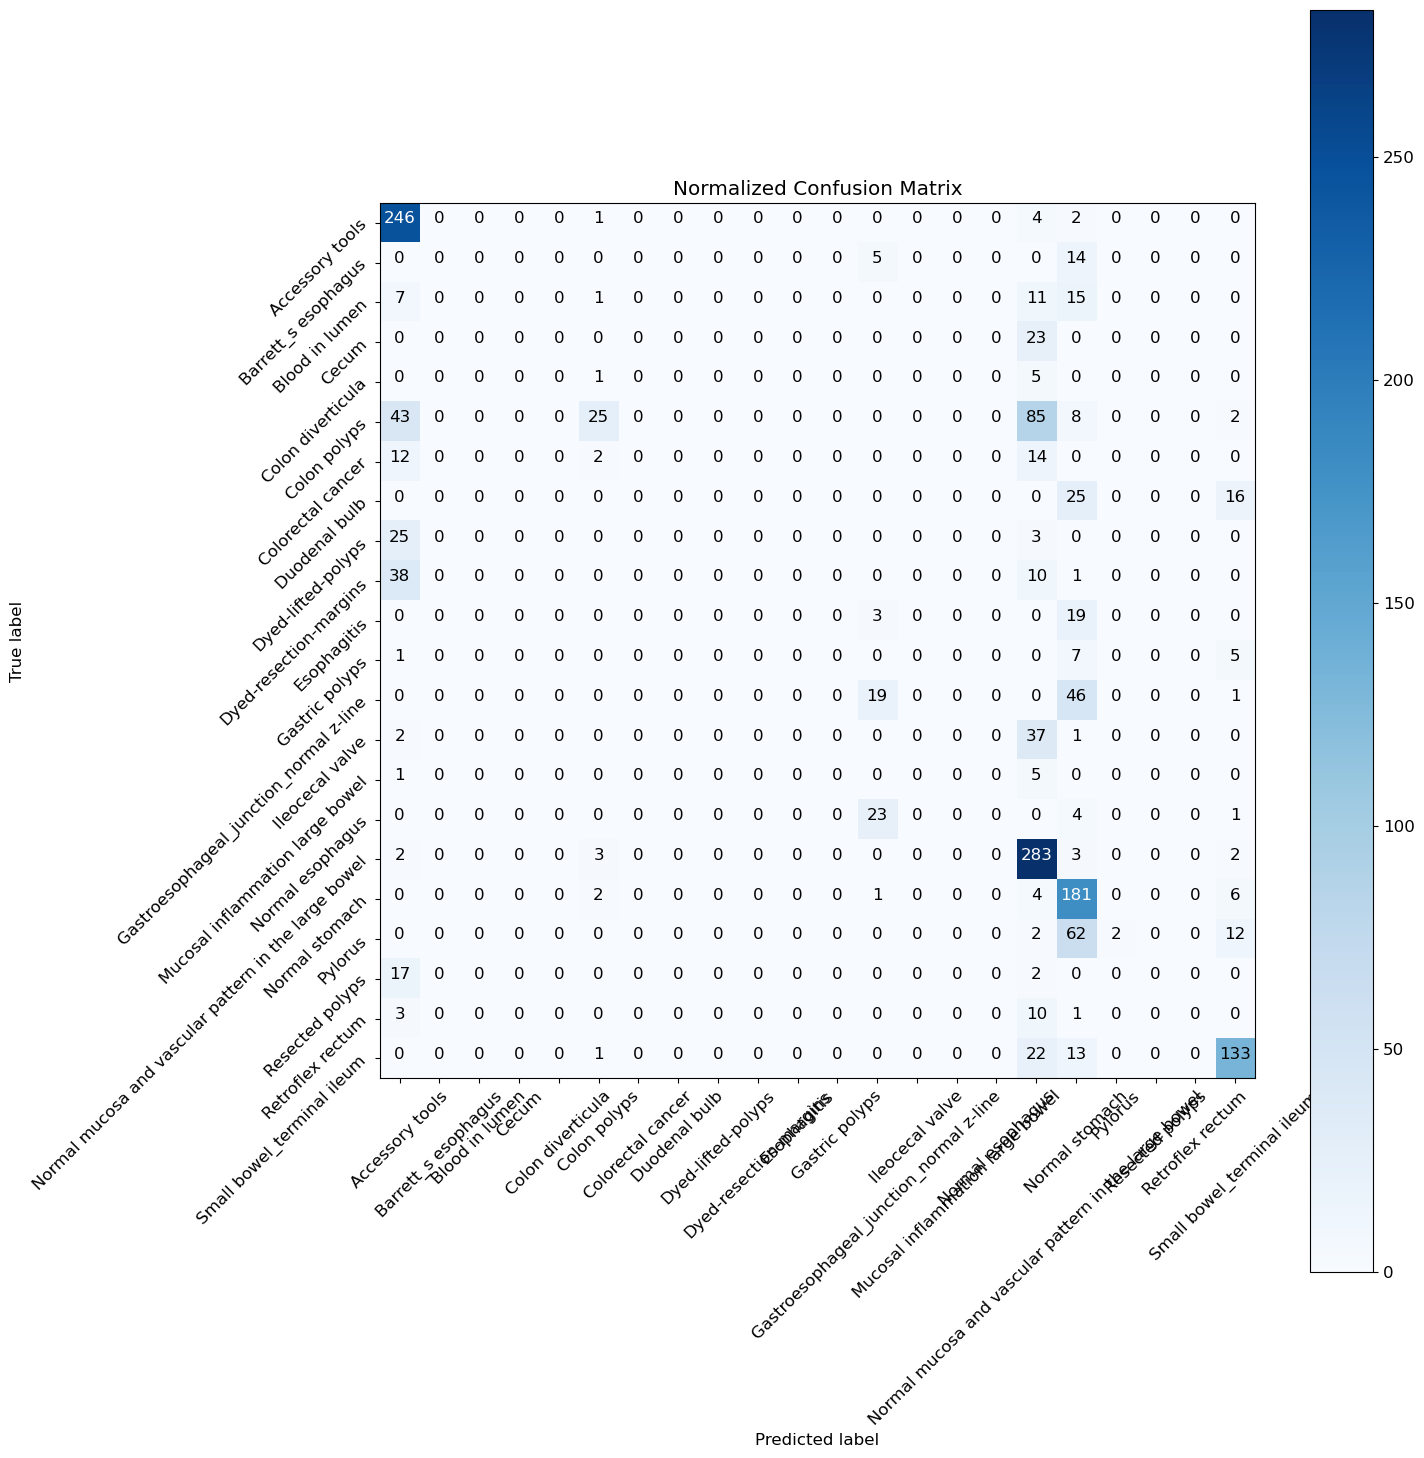

In [53]:

plot_confusion_matrix(conf_matrix, get_labels(test_dataset), normalize=False, title="Normalized Confusion Matrix", figsize=(15, 15),font_size=12)
